In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 베이스 모델

In [2]:
# Train 데이터 불러오기
train_data = pd.read_csv('train.csv')
# Train 데이터를 Train과 Validation 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['Response']),
                                                  train_data['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data['Response'],
                                                  random_state = 31)
# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]
# 전처리를 위한 파이프라인 정의
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])
# 이진 분류를 위한 XGBClassifier 모델 만들기
XGB = XGBClassifier()
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGB)
])
# 모델 훈련하기
model.fit(X_train, y_train)
# Validation 세트로 모델 평가하기
val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {accuracy}")
# Test 데이터 불러오기
test_data = pd.read_csv('test.csv')
# Test 데이터에서 Feature 변수 추출하기
X_test = test_data.drop(columns=['Response'])
# Test 데이터에서 타겟 변수 추출하기
y_test = test_data['Response']
# Test 데이터에서 예측하기
test_pred = model.predict(X_test)
# Test 데이터에서 정확도 평가하기
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy}")
# classification_report를 사용하여 분류 모델의 성능 평가하기
report = classification_report(y_test, test_pred)
print(report)

Validation Accuracy: 0.8785310734463276
Test Accuracy: 0.8552036199095022
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       376
           1       0.52      0.39      0.45        66

    accuracy                           0.86       442
   macro avg       0.71      0.67      0.68       442
weighted avg       0.84      0.86      0.85       442



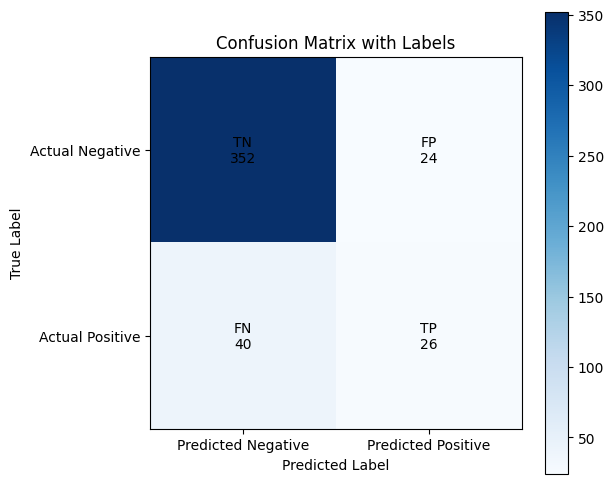

In [3]:
def cm_visualization(expected, predicted):

    cm = confusion_matrix(expected, predicted)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
    plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix with Labels')

    labels = ['TN', 'FP', 'FN', 'TP']
    label_values = [cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]]
    label_colors = ['black', 'black', 'black', 'black']
    indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for label, value, color, (i, j) in zip(labels, label_values, label_colors, indices):
        plt.text(j, i, f'{label}\n{value}', ha='center', va='center', color=color)

    plt.savefig('Confusion_matrix_Base')
    plt.show()

cm_visualization(y_test, test_pred)

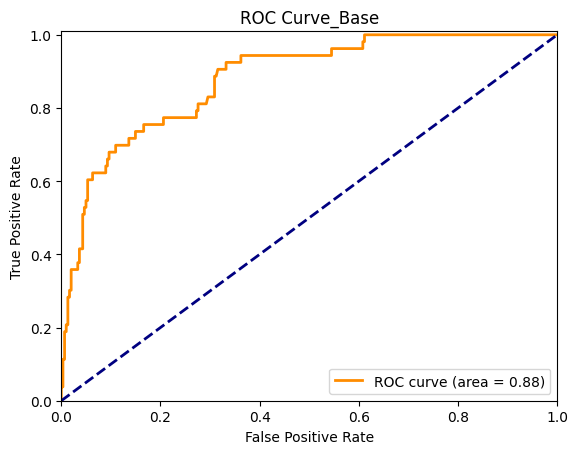

In [4]:
# 모델의 예측 확률 계산하기
y_val_prob = model.predict_proba(X_val)[:, 1]

# ROC 곡선 계산하기
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

# AUC 계산하기
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve_Base')
plt.legend(loc="lower right")
plt.savefig('ROC Curve_base')
plt.show()

## 베이스모델 Epoch별(트리 갯수) 성능 평가

In [ ]:
# Train 데이터 불러오기
train_data = pd.read_csv('train.csv')

# Train 데이터를 Train과 Validation 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['Response']),
                                                  train_data['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data['Response'],
                                                  random_state=100)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# 전처리를 위한 파이프라인 정의
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])

# XGBClassifier 모델 정의
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# n_estimators 값을 1부터 100까지 증가시키면서 모델 훈련 및 평가
n_estimators_list = range(1, 101)
val_accuracies = []
test_accuracies = []

for n in n_estimators_list:
    model.set_params(classifier__n_estimators=n)  # n_estimators 설정 변경
    model.fit(X_train, y_train)  # 모델 훈련
    
    # 검증 세트 정확도 계산
    val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)
    val_accuracies.append(val_accuracy)
    
    # 테스트 세트 정확도 계산
    test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_accuracy)

# 그래프 그리기
plt.plot(n_estimators_list, val_accuracies, label='Validation Accuracy')
plt.plot(n_estimators_list, test_accuracies, label='Test Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy per n_estimators')
plt.legend()
plt.savefig('Base_Model')
plt.show()

# GridSearchCV

In [ ]:
# Train 데이터 불러오기
train_data = pd.read_csv('train.csv')
# Train 데이터를 Train과 Validation 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['Response']),
                                                  train_data['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data['Response'],
                                                  random_state = 31)
# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]
# 전처리를 위한 파이프라인 정의
XGB = XGBClassifier()
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])

# 하이퍼파라미터 범위 지정
param_grid = {
    'n_estimators': [10, 30, 50, 100],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

# GridSearchCV 설정
GS = GridSearchCV(XGB, param_grid=param_grid, cv=5)

# 이진 분류를 위한 XGBClassifier 모델 만들기
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GS)
])

# 모델 훈련하기
model.fit(X_train, y_train)

# 최적의 모델 및 하이퍼파라미터 출력
print("Best Model:", GS.best_estimator_)
print("Best Parameters:", GS.best_params_)

# Validation 세트로 모델 평가하기
val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {accuracy}")

# Test 데이터에서 예측하기
test_pred = model.predict(X_test)

# Test 데이터에서 정확도 평가하기
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy}")

# classification_report를 사용하여 분류 모델의 성능 평가하기
report = classification_report(y_test, test_pred)
print(report)

## GridSearchCV + Lasso

In [ ]:
# Train 데이터 불러오기
train_data = pd.read_csv('train.csv')
# Train 데이터를 Train과 Validation 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['Response']),
                                                  train_data['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data['Response'],
                                                  random_state = 31)
# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]
# 전처리를 위한 파이프라인 정의
XGB = XGBClassifier()
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])

# 하이퍼파라미터 범위 지정
param_grid = {
    'n_estimators': [10, 30, 50, 100],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1, 10]
}

# GridSearchCV 설정
GS = GridSearchCV(XGB, param_grid=param_grid, cv=5)

# 이진 분류를 위한 XGBClassifier 모델 만들기
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GS)
])

# 모델 훈련하기
model.fit(X_train, y_train)

# 최적의 모델 및 하이퍼파라미터 출력
print("Best Model:", GS.best_estimator_)
print("Best Parameters:", GS.best_params_)

# Validation 세트로 모델 평가하기
val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {accuracy}")

# Test 데이터에서 예측하기
test_pred = model.predict(X_test)

# Test 데이터에서 정확도 평가하기
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy}")

# classification_report를 사용하여 분류 모델의 성능 평가하기
report = classification_report(y_test, test_pred)
print(report)

## GridSearchCV + Ridge

In [ ]:
# Train 데이터 불러오기
train_data = pd.read_csv('train.csv')
# Train 데이터를 Train과 Validation 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['Response']),
                                                  train_data['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data['Response'],
                                                  random_state = 31)
# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]
# 전처리를 위한 파이프라인 정의
XGB = XGBClassifier()
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])

# 하이퍼파라미터 범위 지정
param_grid = {
    'n_estimators': [10, 30, 50, 100],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'reg_lambda': [0, 0.1, 0.5, 1, 10]
}

# GridSearchCV 설정
GS = GridSearchCV(XGB, param_grid=param_grid, cv=5)

# 이진 분류를 위한 XGBClassifier 모델 만들기
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GS)
])

# 모델 훈련하기
model.fit(X_train, y_train)

# 최적의 모델 및 하이퍼파라미터 출력
print("Best Model:", GS.best_estimator_)
print("Best Parameters:", GS.best_params_)

# Validation 세트로 모델 평가하기
val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {accuracy}")

# Test 데이터에서 예측하기
test_pred = model.predict(X_test)

# Test 데이터에서 정확도 평가하기
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy}")

# classification_report를 사용하여 분류 모델의 성능 평가하기
report = classification_report(y_test, test_pred)
print(report)

In [ ]:
# 모델의 예측 확률 계산하기
y_val_prob = model.predict_proba(X_val)[:, 1]

# ROC 곡선 계산하기
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

# AUC 계산하기
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 피쳐 선택

In [ ]:
# Train 데이터 불러오기
train_data = pd.read_csv('train.csv')
# Train 데이터를 Train과 Validation 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['Response']),
                                                  train_data['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data['Response'],
                                                  random_state = 31)
# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]
# 전처리를 위한 파이프라인 정의
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])
# 이진 분류를 위한 XGBClassifier 모델 만들기
XGB = XGBClassifier()
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGB)
])
# 모델 훈련하기
model.fit(X_train, y_train)
# Validation 세트로 모델 평가하기
val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {accuracy}")
# Test 데이터 불러오기
test_data = pd.read_csv('test.csv')
# Test 데이터에서 Feature 변수 추출하기
X_test = test_data.drop(columns=['Response'])
# Test 데이터에서 타겟 변수 추출하기
y_test = test_data['Response']
# Test 데이터에서 예측하기
test_pred = model.predict(X_test)
# Test 데이터에서 정확도 평가하기
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy}")
# classification_report를 사용하여 분류 모델의 성능 평가하기
report = classification_report(y_test, test_pred)
print(report)

In [ ]:
# XGBoost 모델에서 각 피처의 중요도 값을 확인하기
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(input_features=categorical_cols)
numeric_features = numeric_cols

# 범주형 변수의 중요도와 수치형 변수의 중요도를 결합하여 확인
feature_importance_dict = dict(zip(np.concatenate((feature_names, numeric_features)), importances))
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 시각화를 위한 준비
features, importance_values = zip(*sorted_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importance_values, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.savefig('Feature Importrances')
plt.show()

In [ ]:
columns = ['Teenhome','Recency','MntWines','MntGoldProds','NumWebVisitsMonth','Marital_Status','NumStorePurchases',
           'NumCatalogPurchases','MntMeatProducts','Income','Education','Response']

In [ ]:
# Train 데이터 불러오기
train_data = pd.read_csv('train.csv')
train_data = train_data[columns]
# Train 데이터를 Train과 Validation 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['Response']),
                                                  train_data['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data['Response'],
                                                  random_state = 31)
# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]
# 전처리를 위한 파이프라인 정의
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])
# 이진 분류를 위한 XGBClassifier 모델 만들기
XGB = XGBClassifier()
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGB)
])
# 모델 훈련하기
model.fit(X_train, y_train)
# Validation 세트로 모델 평가하기
val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {accuracy}")
# Test 데이터 불러오기
test_data = pd.read_csv('test.csv')
# Test 데이터에서 Feature 변수 추출하기
X_test = test_data.drop(columns=['Response'])
# Test 데이터에서 타겟 변수 추출하기
y_test = test_data['Response']
# Test 데이터에서 예측하기
test_pred = model.predict(X_test)
# Test 데이터에서 정확도 평가하기
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy}")
# classification_report를 사용하여 분류 모델의 성능 평가하기
report = classification_report(y_test, test_pred)
print(report)

In [ ]:
def cm_visualization(expected, predicted):

    cm = confusion_matrix(expected, predicted)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
    plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix with Labels')

    labels = ['TN', 'FP', 'FN', 'TP']
    label_values = [cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]]
    label_colors = ['black', 'black', 'black', 'black']
    indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for label, value, color, (i, j) in zip(labels, label_values, label_colors, indices):
        plt.text(j, i, f'{label}\n{value}', ha='center', va='center', color=color)

    plt.savefig('Confusion_matrix_feature')
    plt.show()

cm_visualization(y_test, test_pred)

In [ ]:
# 모델의 예측 확률 계산하기
y_val_prob = model.predict_proba(X_val)[:, 1]

# ROC 곡선 계산하기
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

# AUC 계산하기
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve_feature')
plt.legend(loc="lower right")
plt.savefig('ROC Curve_feature')
plt.show()

# PCA

In [ ]:
from sklearn.decomposition import PCA

# Train 데이터 불러오기
train_data = pd.read_csv('train.csv')
# Train 데이터를 Train과 Validation 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['Response']),
                                                  train_data['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data['Response'],
                                                  random_state = 31)
# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]
# 전처리를 위한 파이프라인 정의
XGB = XGBClassifier()
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])

# PCA를 사용하여 차원 축소
pca = PCA(n_components=10)

# 이진 분류를 위한 XGBClassifier 모델 만들기
model = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', XGB)
])

# 하이퍼파라미터 범위 지정
param_grid = {
    'classifier__n_estimators': [10, 30, 50, 100],
    'classifier__max_depth': [3, 5, 7, 9, 11],
    'classifier__eta': [0.01, 0.05, 0.1, 0.2, 0.3],
    'classifier__reg_lambda': [0, 0.1, 0.5, 1, 10]
}

# GridSearchCV 설정
GS = GridSearchCV(model, param_grid=param_grid, cv=5)

# 모델 훈련하기
GS.fit(X_train, y_train)

# 최적의 모델 및 하이퍼파라미터 출력
print("Best Model:", GS.best_estimator_)
print("Best Parameters:", GS.best_params_)

# Validation 세트로 모델 평가하기
val_pred = GS.predict(X_val)
accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {accuracy}")

# Test 데이터에서 예측하기
test_pred = GS.predict(X_test)

# Test 데이터에서 정확도 평가하기
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy}")

# classification_report를 사용하여 분류 모델의 성능 평가하기
report = classification_report(y_test, test_pred)
print(report)

In [ ]:
def cm_visualization(expected, predicted):

    cm = confusion_matrix(expected, predicted)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
    plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix with Labels')

    labels = ['TN', 'FP', 'FN', 'TP']
    label_values = [cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]]
    label_colors = ['black', 'black', 'black', 'black']
    indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for label, value, color, (i, j) in zip(labels, label_values, label_colors, indices):
        plt.text(j, i, f'{label}\n{value}', ha='center', va='center', color=color)

    plt.savefig('Confusion_matrix_PCA')
    plt.show()

cm_visualization(y_test, test_pred)

# OverSampling

## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Train 데이터 불러오기
train_data = pd.read_csv('train.csv')
# Train 데이터를 Train과 Validation 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['Response']),
                                                  train_data['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data['Response'],
                                                  random_state = 31)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# 전처리를 위한 파이프라인 정의
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])

# Encoding 적용
X_train_encoded = preprocessor.fit_transform(X_train)
X_val_encoded = preprocessor.transform(X_val)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# 하이퍼파라미터 범위 지정
param_grid = {
    'n_estimators': [10, 30, 50, 100],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'reg_lambda': [0, 0.1, 0.5, 1, 10]
}

# 이진 분류를 위한 XGBClassifier 모델 만들기
XGB = XGBClassifier()

# 모델 설정
model = GridSearchCV(XGB, param_grid=param_grid, cv=5)

# 모델 훈련하기
history = model.fit(X_train_encoded, y_train)

# 최적의 모델 및 하이퍼파라미터 출력
print("Best Model:", model.best_estimator_)
print("Best Parameters:", model.best_params_)

# Validation 세트로 모델 평가하기
val_pred = model.predict(X_val_encoded)
accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {accuracy}")

# Test 데이터 불러오기
test_data = pd.read_csv('test.csv')

X_test = test_data.drop('Response', axis = 1)
y_test = test_data['Response']

# One-Hot Encoding 및 표준화 적용
X_test_encoded = preprocessor.transform(X_test)

# Test 데이터에서 예측하기
test_pred = model.predict(X_test_encoded)

# Test 데이터에서 정확도 평가하기
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy}")

# classification_report를 사용하여 분류 모델의 성능 평가하기
report = classification_report(y_test, test_pred)
print(report)

# 훈련 과정에서 정확도 추적
train_accuracy = history.cv_results_['mean_test_score']

# 검증 세트의 정확도 추적
val_accuracy = model.cv_results_['mean_test_score']

# 에포크별 정확도 시각화
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy per Epoch')
plt.show()

In [ ]:
def cm_visualization(expected, predicted):

    cm = confusion_matrix(expected, predicted)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
    plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix with Labels')

    labels = ['TN', 'FP', 'FN', 'TP']
    label_values = [cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]]
    label_colors = ['black', 'black', 'black', 'black']
    indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for label, value, color, (i, j) in zip(labels, label_values, label_colors, indices):
        plt.text(j, i, f'{label}\n{value}', ha='center', va='center', color=color)

    plt.savefig('Confusion_matrix')
    plt.show()

cm_visualization(y_test, test_pred)

In [ ]:
# 모델의 예측 확률 계산하기
y_val_prob = model.predict_proba(X_val_encoded)[:, 1]

# ROC 곡선 계산하기
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

# AUC 계산하기
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('ROC Curve')
plt.show()

## ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN

# Train 데이터 불러오기
train_data = pd.read_csv('train.csv')
# Train 데이터를 Train과 Validation 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['Response']),
                                                  train_data['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data['Response'],
                                                  random_state = 31)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# 전처리를 위한 파이프라인 정의
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])

# Encoding 적용
X_train_encoded = preprocessor.fit_transform(X_train)
X_val_encoded = preprocessor.transform(X_val)

# ADASYN 적용
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_encoded, y_train)

# 하이퍼파라미터 범위 지정
param_grid = {
    'n_estimators': [10, 30, 50, 100],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'reg_lambda': [0, 0.1, 0.5, 1, 10]
}

# 이진 분류를 위한 XGBClassifier 모델 만들기
XGB = XGBClassifier()

# 모델 설정
model = GridSearchCV(XGB, param_grid=param_grid, cv=5)

# 모델 훈련하기
model.fit(X_train_encoded, y_train)

# 최적의 모델 및 하이퍼파라미터 출력
print("Best Model:", model.best_estimator_)
print("Best Parameters:", model.best_params_)

# Validation 세트로 모델 평가하기
val_pred = model.predict(X_val_encoded)
accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {accuracy}")

# Test 데이터 불러오기
test_data = pd.read_csv('test.csv')

X_test = test_data.drop('Response', axis = 1)
y_test = test_data['Response']

# One-Hot Encoding 및 표준화 적용
X_test_encoded = preprocessor.transform(X_test)

# Test 데이터에서 예측하기
test_pred = model.predict(X_test_encoded)

# Test 데이터에서 정확도 평가하기
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy}")

# classification_report를 사용하여 분류 모델의 성능 평가하기
report = classification_report(y_test, test_pred)
print(report)